# Preprocessing data to csv / pandas format using Xarray
[xarray](http://xarray.pydata.org/en/stable/) is this awesome package for working with multidimensional data. The major benefit is the labelled axes, making code more readable.

In [1]:
# pip install xarray
# conda install xarray dask netCDF4 bottleneck

In [173]:
import os
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path

from typing import Optional, List, Dict, Tuple, Union

import matplotlib.pyplot as plt

In [12]:
# set the working directory
if Path('.').absolute().parents[0].name == 'gp_drought':
    os.chdir('..')

assert Path(os.getcwd()).name == 'gp_drought'
print(Path(os.getcwd()))

/Users/tommylees/github/gp_drought


In [15]:
data_dir = Path('data')
# data_dir = 'Data'
path_to_nc = os.path.join(data_dir, 'data_kenya.nc')

assert Path(path_to_nc).exists()
print(path_to_nc)

data/data_kenya.nc


# Read in data

In [16]:
# open in xarray and view the dataset
ds = xr.open_dataset(path_to_nc)
ds

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 216)
Coordinates:
  * lat         (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.25 -4.5 -4.75 -5.0
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2019-11-30
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    VCI3M       (time, lat, lon) float64 ...
    boku_VCI    (time, lat, lon) float64 ...
    modis_ndvi  (time, lat, lon) float64 ...

In [170]:
def stack_da_to_df(da: xr.DataArray) -> pd.DataFrame:
    """create a timeseries dataframe with each column as a pixel and each row a timestep"""
    assert isinstance(da, xr.DataArray), "Works only with DataArray (1 Variable Datasets)"
    stacked = da.stack(pixel=['lat', 'lon'])
    pixels = stacked.pixel.values
    
    # get the times, pixel map (id: (lat, lon)), and column rename map
    pixel_map = {i: pxl for i, pxl in enumerate(pixels)}
    column_map  = {f"VCI_{pixel_id}" for pixel_id in pixel_map.keys()}
    times = [pd.to_datetime(t) for t in stacked.time.values]
    
    return pd.DataFrame(
        stacked.values, 
        columns=[f"VCI_{pixel_id}" for pixel_id in pixel_map.keys()], 
        index=times
    )

In [171]:
stacked_df = stack_da_to_df(ds['boku_VCI'].isel(lat=slice(0, 5), lon=slice(0, 5)))
stacked_df.head()

,VCI_0,VCI_1,VCI_2,VCI_3,VCI_4,VCI_5,VCI_6,VCI_7,VCI_8,VCI_9,...,VCI_15,VCI_16,VCI_17,VCI_18,VCI_19,VCI_20,VCI_21,VCI_22,VCI_23,VCI_24
2001-12-31,43.718593,31.132075,85.882353,20.183486,58.447489,63.900415,72.123894,65.695793,87.570621,61.691542,...,41.538462,94.464945,77.238806,62.857143,6.666667e+01,60.080645,58.102767,37.549407,100.000000,1.000000e+02
2002-01-31,2.843602,16.078431,33.333333,78.169014,67.796610,56.603774,45.086705,24.409449,58.723404,64.541833,...,20.105820,66.666667,33.816425,30.687831,2.695312e+01,19.004525,11.956522,0.000000,62.886598,3.098592e+01
2002-02-28,34.337349,29.411765,1.973684,56.818182,33.854167,16.842105,21.052632,30.000000,47.651007,48.514851,...,10.389610,21.354167,16.176471,1.834862,-3.552714e-15,0.000000,9.411765,0.000000,14.388489,7.105427e-15
2002-03-31,50.000000,34.065934,23.602484,44.715447,20.138889,32.203390,18.461538,24.657534,21.551724,34.722222,...,20.270270,16.935484,21.875000,5.714286,-3.552714e-15,12.244898,13.559322,0.000000,0.000000,3.194444e+01
2002-04-30,54.945055,90.322581,43.930636,73.722628,75.949367,62.857143,76.282051,47.023810,66.197183,73.964497,...,50.310559,36.521739,71.005917,39.682540,2.315271e+01,79.545455,25.490196,3.773585,1.973684,7.608696e+00


In [172]:
x_axis_labels = stacked_df.index.map(lambda x: '%s-%s-%s' % (x.year,x.month,x.day))
x_axis_labels

Index(['2001-12-31', '2002-1-31', '2002-2-28', '2002-3-31', '2002-4-30',
       '2002-5-31', '2002-6-30', '2002-7-31', '2002-8-31', '2002-9-30',
       ...
       '2019-2-28', '2019-3-31', '2019-4-30', '2019-5-31', '2019-6-30',
       '2019-7-31', '2019-8-31', '2019-9-30', '2019-10-31', '2019-11-30'],
      dtype='object', length=216)

In [23]:
def plot_series(series, cols, new_names, x_axis=None):
    """Plot a time series of dataframe"""
    df = series.copy()
    fig, ax = plt.subplots(figsize=(18, 8))
    for col, name in zip(cols, new_names):
        df.rename(columns={col: name}, inplace=True)
    df[new_names].plot(ax=ax)
    ax.set_title('VCI (Vegetation Condition Index) for two pixels')
    ax.set_xlabel('time')
    ax.set_ylabel('VCI')
    
    plt.legend(fontsize=14, loc='best')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)

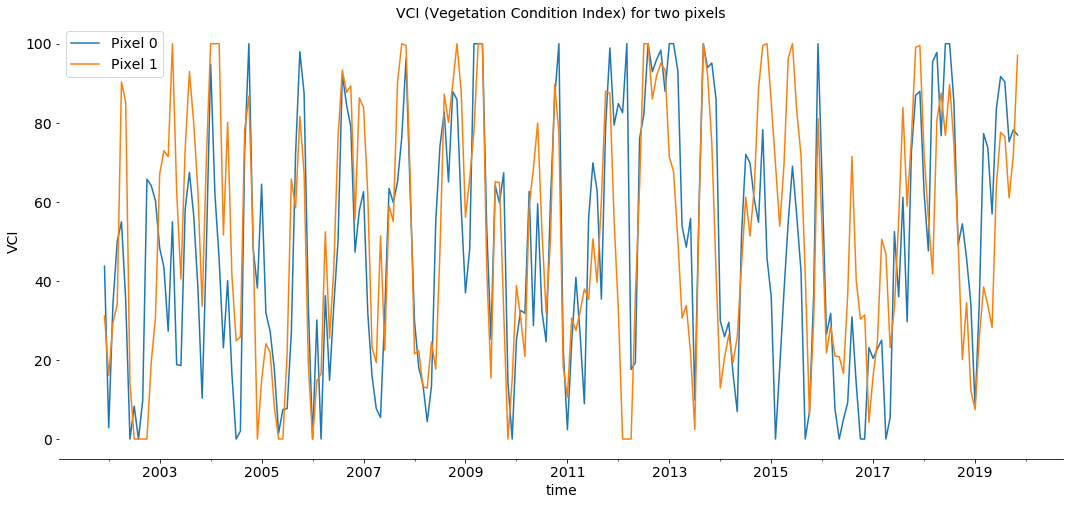

In [24]:
plot_series(stacked_df, cols=['VCI_0','VCI_1'], new_names=["Pixel 0", "Pixel 1"])

# Infer daily VCI Scores

In [25]:
import gpflow

/Users/tommylees/miniconda3/envs/crop/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [26]:
print(gpflow.__version__)

1.5.1


Install the non-GPU accelerated GPFlow 1.5 via: `pip install gpflow`

# Preprocess Data

In [201]:
def rescale_df(df: pd.DataFrame) -> Tuple[pd.DataFrame, Union[pd.Series, float], Union[pd.Series, float]]:
    """"""
    column_means = df.mean()
    column_stds = df.std()

    scaled_df = (df - column_means)/ (column_stds)

    return scaled_df, column_means, column_stds


def convert_df_to_output_resolution(df: pd.DataFrame, resample_str: str = 'D') -> Tuple[pd.DataFrame, pd.DatetimeIndex]:
    """Take a timeseries at one time resolution and convert to a format
    for going from INPUT -> OUTPUT resolution
    """
    df_resampled = df.resample(resample_str).mean()
    
    # in case using multiple datasets good to have a record
    # of the timestamps for selecting the correct times
    date_index = df_frame.index
    
    # reset the index to integers
    if resample_str == 'D':
        # calculate days since the first day
        df_resampled.index = [i for i in range(len(df_frame.index))] # (df_frame.index - df_frame.index[0]).days
    else:
        # TODO
        assert False, "only written for DAILY downscaling so far"
        df_resampled.index = [i for i in range(len(df_frame.index))]
        
    return df_resampled, date_index

In [209]:
# PREPROCESSING
scaled_df, column_means, column_stds = rescale_df(stacked_df)
df_resampled, date_index = convert_df_to_output_resolution(scaled_df, resample_str='D')
original_data = (df_resampled * column_stds) + column_means

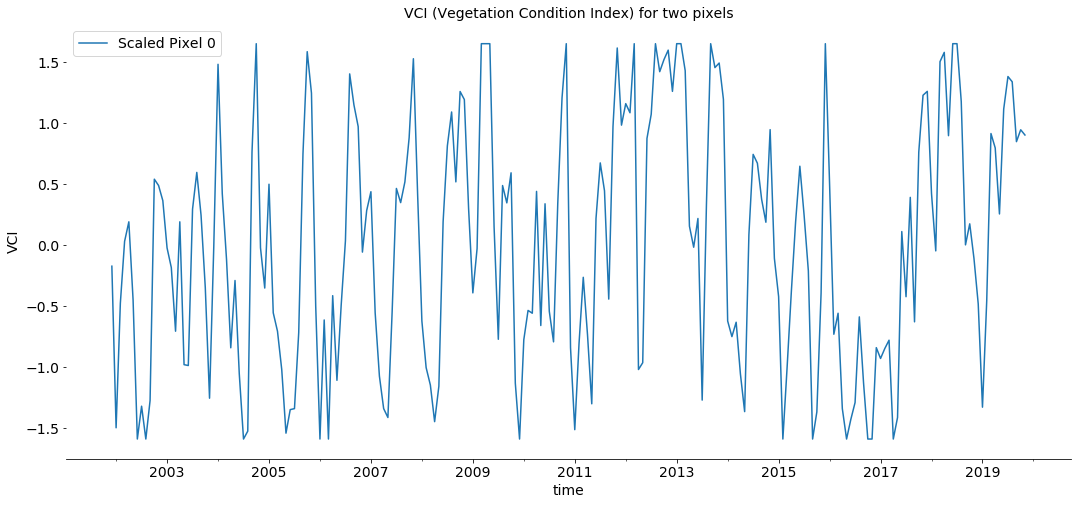

In [210]:
# Rescaled data
plot_series(scaled_df, cols=['VCI_0'], new_names=["Scaled Pixel 0"])

## Using pandas Interpolate function (no uncertainty)

From monthly -> daily values

In [218]:
interpolated_df = df_resampled.interpolate()
interpolated_df = (interpolated_df * column_stds) + column_means

In [219]:
print("Monthly Data: ", scaled_df.shape)
print("Daily Data: ", interpolated_df.shape)

Monthly Data:  (216, 25)
Daily Data:  (6544, 25)


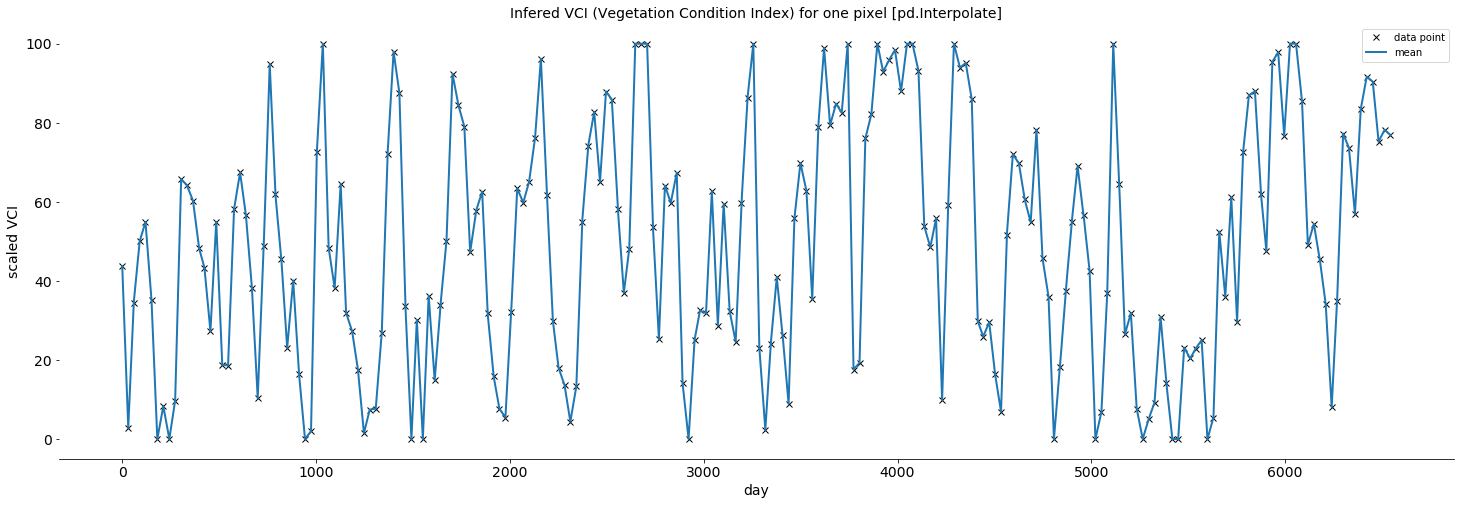

In [220]:
fig, ax = plt.subplots(figsize=(25, 8))

# observations
plt.plot(df_frame.index, original_data.VCI_0, 'kx', mew=1, label="data point")

# mean prediction
ax.plot(x_test, interpolated_df.VCI_0, lw=2, label="mean")

ax.set_title(f'Infered VCI (Vegetation Condition Index) for one pixel [pd.Interpolate]')
ax.set_xlabel('day')
ax.set_ylabel('scaled VCI')

plt.legend(fontsize=14, loc='best')

# making the plot pretty
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                  + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend();

In [221]:
# ?df.interpolate

## Gaussian Process Regression

- different kernel options
- think about priors on GP hyperparameters
- different data normalisations options

NOTE:
```
df_frame.dropna().index.to_numpy()

-->

df_frame.dropna().index.values
```

In [222]:
assert pd.__version__ == '0.23.4', "Are we using the same version of Pandas? Tommy: 0.23.4"

In [307]:
def create_xy_arrays(series: pd.Series, std: float, mean: float) -> Tuple[np.array, np.array, np.array]:
    """create the x_train / y_train pairs
    
    x_train: np.array[float]
        array of real numbers representing time
    y_train: np.array[float]
        the values of the time-series that 
        
    Note: 
    - assumes the y_data is normalised using: $((y - mean) / std)$
    """
    # drop the nans and return the index values
    x_train = series.dropna().index.values.astype(float).reshape(-1,1)
    
    # normalised 
    y_train_norm = series.dropna().values.astype(float).reshape(-1,1)
    
    # un-normalised
    y_train_orig = (y_train_norm * std) + mean
    
    assert y_train.shape == x_train.shape
    assert y_train_norm.shape == y_train.shape
    
    return x_train, y_train_norm, y_train_orig

In [308]:
x_train, y_train, y_train_orig = create_xy_arrays(
    df_resampled.VCI_0, column_stds.VCI_0, column_means.VCI_0
)

print((x_train.shape), (y_train.shape))

(216, 1) (216, 1)


In [309]:
# Here you are including the actual training points as test points 
# - to let the GP update the potentially noisy observation in x_train
x_test = df_frame.index.values.astype(float).reshape(-1,1)
x_test.shape

(6544, 1)

### here you setup the GP regression
- What does no prior mean? Surely we require a prior for computation?
- What actually is a kernel?
- when we are optimizing are we optimizing the values of the 
```
GPR/kern/lengthscales
GPR/kern/variance
GPR/likelihood/variance
```
- what assumptions are we making using these models?
- The variance and mean only have one value for each prediction (not MCMC sampled?)

In [310]:
# dir(gpflow.priors)
# ?gpflow.kernels.RBF

In [320]:
def squared_exponential_GPR(x_train: np.array, y_train: np.array, variance: float = 0.5, lengthscales: float = 30) -> gpflow.models.GPR:
    """Create a GP Regression
    - a Squared Exponential covariance function (RBF Kernel)
    - Gaussian likelihood function
    """
    assert x_train.shape == y_train.shape
    input_dim = x_train.shape[-1]
    
    # create SE cov function
    se_cov_function = gpflow.kernels.RBF(input_dim=input_dim, variance=variance, lengthscales=lengthscales)
    # gaussian likelihood
    likelihood = gpflow.likelihoods.Gaussian()
    # GPR model
    model = gpflow.models.GPR(x_train, y_train, kern=se_cov_function)
    
    # play with PRIORS
    # You can play with hyperparameter priors if you like
    # m.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
    # m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
    # m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
    
    model.clear()
    model.compile()
    
    return model


def fit_model(model: gpflow.models.GPR) -> None:
    """Optimize the parameters of the GP Regression model (lengthscales, variance).
    """
    opt = gpflow.train.ScipyOptimizer()
    opt.minimize(model)

    
def predict(model: gpflow.models.GPR, x_test: np.array, rescale: Optional[Tuple[float, float]] = None) -> Tuple[np.array, np.array]:
    """"""
    # Predict all test points 
    (mean, var) = model.predict_y(x_test)
    
    if rescale is not None:
        rescale_mean, rescale_std = rescale
        mean = (mean * rescale_std) + rescale_mean
        var = (var * rescale_std)
        
    return mean, var


def plot_gp(mean: np.array, var: np.array, x_train: np.array, y_train: np.array, title: str = ''):
    """
    - Plot the observed points as black crosses ('kx')
    - Plot the mean conditions as a solid line
    - Plot confidence intervals as blue shading around the mean
    """
    assert y_train.shape == x_train.shape
    assert mean.shape == var.shape
    fig, ax = plt.subplots(figsize=(25, 8))
    
    # observations
    plt.plot(x_train, y_train, 'kx', mew=1, label="data point")
    
    # mean prediction
    ax.plot(x_test, mean, lw=2, label="mean")
    
    # confidence intervals
    plt.fill_between(
        x_test[:,0], 
        mean[:,0] - 2 * np.sqrt(var[:,0]), # y-lower
        mean[:,0] + 2 * np.sqrt(var[:,0]), # y-upper
        color='blue', alpha=0.2, label="confidence"
    )

    ax.set_title('GP Infered VCI (Vegetation Condition Index) for one pixel %s' %title)
    ax.set_xlabel('day')
    ax.set_ylabel('scaled VCI')

    plt.legend(fontsize=14, loc='best')
    
    # making the plot pretty
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]
                      + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(14)


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    return fig, ax

In [315]:
model = squared_exponential_GPR(x_train, y_train)
fit_model(model)
mean, var = predict(model, x_test, rescale=(column_means.VCI_0, column_stds.VCI_0))

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-80479e13-282/X/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File 

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-80479e13-282/X/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File 

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-80479e13-282/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File 

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-80479e13-282/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()  File 

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-62665ab3-273/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    s

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-62665ab3-273/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    s

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-62665ab3-273/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'SquaredExponential-62665ab3-273/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-80479e13-282/likelihood/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_l

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-80479e13-282/likelihood/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_l

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 242.220386
  Number of iterations: 16
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 242.220386
  Number of iterations: 16
  Number of functions evaluations: 18


In [316]:
model

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,39.67555348824221
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.8513277230358434
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.14032227188703061


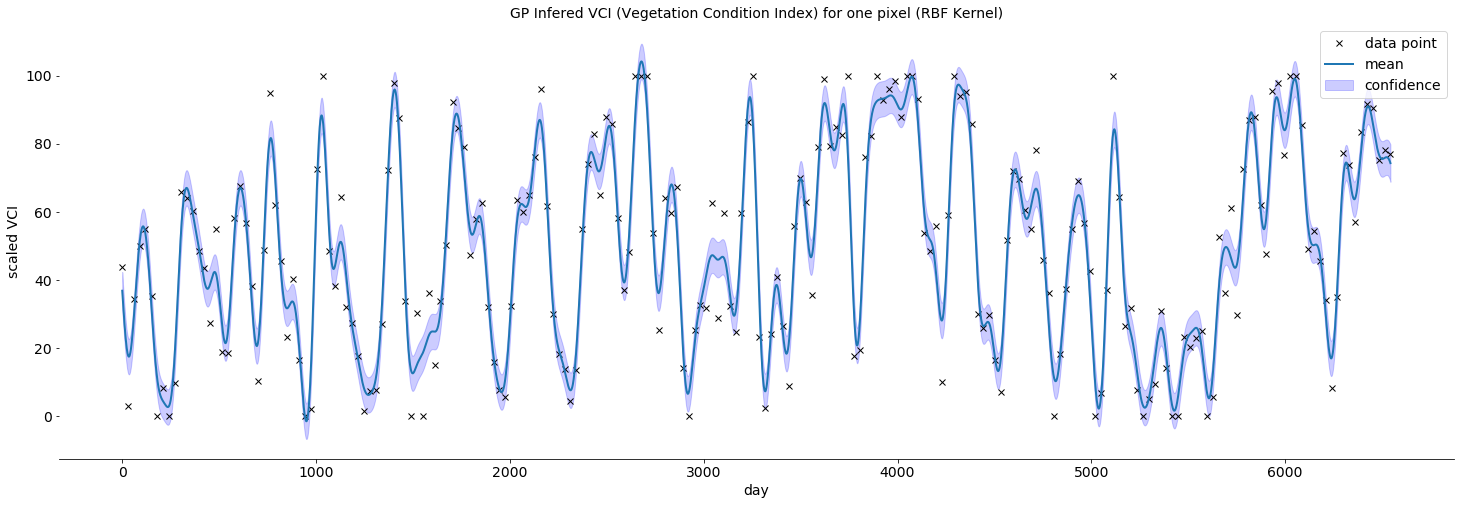

In [319]:
plot_gp(mean, var, x_train, y_train_orig, title="(RBF Kernel)");

### How good are the GP Predictions at recreating the TRUE DEKAD OBSERVATIONS?

In [123]:
path = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/interim/boku_ndvi_1000_preprocessed_DEKAD/data_kenya.nc')

ds_dekad = xr.open_dataset(path)
# df_dekad = stack_da_to_df(ds_dekad.boku_VCI.isel(lat=slice(0, 5), lon=slice(0,5)))

In [124]:
# the dekad data has an error with calculation of VCI
# recalculate the VCI here !
if False:
    wd = Path('.').absolute()

    if Path('/Users/tommylees/github/ml_drought').exists():
        os.chdir(Path('/Users/tommylees/github/ml_drought'))
        from src.analysis import ConditionIndex

        vci = ConditionIndex(ds=ds_dekad, resample_str=None)  # .isel(lat=slice(0, 5), lon=slice(0,5))
        variable = 'modis_ndvi'
        vci.fit(variable=variable, rolling_window=1)
        var_ = [v for v in vci.index.data_vars][0]
        vci = vci.index.rename({var_: f"VCI"})

        ds_dekad['boku_VCI'] = (vci.VCI)
        ds_dekad.to_netcdf(path.parents[0] / 'data_kenya_VALID.nc')

        os.chdir(wd)
        print(Path(os.getcwd()))

In [125]:
df_dekad = stack_da_to_df(vci.VCI)
df_dekad.head()

,VCI_0,VCI_1,VCI_2,VCI_3,VCI_4,VCI_5,VCI_6,VCI_7,VCI_8,VCI_9,...,VCI_15,VCI_16,VCI_17,VCI_18,VCI_19,VCI_20,VCI_21,VCI_22,VCI_23,VCI_24
2001-12-10,62.000000,61.904762,43.518519,88.034188,92.380952,53.921569,97.000000,77.570093,68.354430,64.601770,...,67.441860,75.000000,72.268908,93.421053,70.588235,61.904762,53.763441,88.461538,42.307692,62.921348
2001-12-20,65.000000,62.857143,43.518519,94.871795,100.000000,44.117647,95.000000,79.439252,70.886076,70.796460,...,59.302326,71.590909,69.747899,97.368421,64.705882,57.142857,46.236559,89.423077,28.846154,62.921348
2001-12-31,35.000000,33.333333,20.370370,100.000000,88.571429,39.215686,89.000000,55.140187,55.696203,62.831858,...,60.465116,64.772727,50.420168,67.105263,55.294118,17.857143,24.731183,72.115385,30.769231,59.550562
2002-01-10,31.818182,24.358974,14.285714,70.940171,51.818182,32.000000,70.270270,50.000000,41.975309,40.196078,...,67.415730,61.111111,36.000000,59.793814,65.168539,22.471910,29.411765,51.086957,80.645161,71.910112
2002-01-20,13.636364,5.128205,0.000000,62.393162,27.272727,18.666667,62.162162,33.333333,24.691358,28.431373,...,57.303371,45.833333,31.000000,51.546392,59.550562,2.247191,17.647059,31.521739,80.645161,68.539326


In [146]:
frame_dekad = df_dekad.resample('D').mean()
frame_dekad = frame_dekad.loc[days_to_keep]
frame_dekad.index = (frame_dekad.index - frame_dekad.index[0]).days

dekad_x = frame_dekad['VCI_0'].index
dekad_y = frame_dekad['VCI_0']


/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


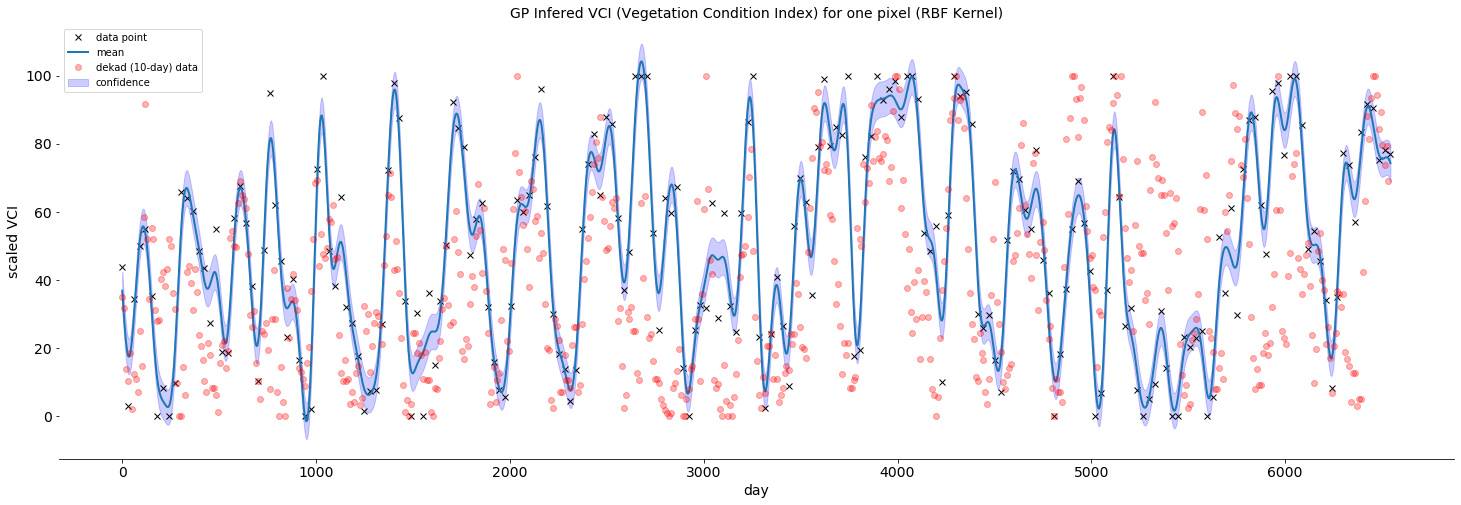

In [152]:
fig, ax = plot_gp(rescaled_mean,rescaled_var, title="(RBF Kernel)");
ax.plot(dekad_x, dekad_y, 'ro', mew=1, alpha=0.3, label="dekad (10-day) data")
plt.legend()

# Or use a Mattern kernel - for less smooth dynamics

Questions: 
- What are the impact of changing the parameters of the kernel?
- How do we change the likelihood? ..

In [163]:
mattern_kernel = gpflow.kernels.Matern32(1, variance=0.5, lengthscales=30)
likelihood = gpflow.likelihoods.Gaussian()
model2 = gpflow.models.GPR(x_train, y_train_norm, kern=mattern_kernel)
model2.clear()

# You can play with hyperparameter priors if you like
# m.kern.lengthscales.prior = gpflow.priors.inv Gamma(1., 1.)
# m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
# m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
model2.compile()
model2.as_pandas_table()

opt = gpflow.train.ScipyOptimizer()
opt.minimize(model2)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-c0968875-51/X/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3339, in run_code
    return outflag  File "<ipython-input-163-cfcc8336d2a3>", line 3, in <module>
    model2 = gpflow.models.GPR(x_train, y_train_norm, kern=mattern_kernel)  File "</Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/decorator.py:decorator-gen-177>", line 2, in __init__  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/node.py", line 156, in build
    self._

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-c0968875-51/X/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3339, in run_code
    return outflag  File "<ipython-input-163-cfcc8336d2a3>", line 3, in <module>
    model2 = gpflow.models.GPR(x_train, y_train_norm, kern=mattern_kernel)  File "</Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/decorator.py:decorator-gen-177>", line 2, in __init__  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/node.py", line 156, in build
    self._

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-c0968875-51/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3339, in run_code
    return outflag  File "<ipython-input-163-cfcc8336d2a3>", line 3, in <module>
    model2 = gpflow.models.GPR(x_train, y_train_norm, kern=mattern_kernel)  File "</Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/decorator.py:decorator-gen-177>", line 2, in __init__  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/node.py", line 156, in build
    self._

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-c0968875-51/Y/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3339, in run_code
    return outflag  File "<ipython-input-163-cfcc8336d2a3>", line 3, in <module>
    model2 = gpflow.models.GPR(x_train, y_train_norm, kern=mattern_kernel)  File "</Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/decorator.py:decorator-gen-177>", line 2, in __init__  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/node.py", line 156, in build
    self._

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern32-dcf2173b-42/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3339, in run_code
    return outflag  File "<ipython-input-163-cfcc8336d2a3>", line 1, in <module>
    mattern_kernel = gpflow.kernels.Matern32(1, variance=1, lengthscales=30)  File "</Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/decorator.py:decorator-gen-135>", line 2, in __init__  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/node.py", line 156, i

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern32-dcf2173b-42/lengthscales/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3339, in run_code
    return outflag  File "<ipython-input-163-cfcc8336d2a3>", line 1, in <module>
    mattern_kernel = gpflow.kernels.Matern32(1, variance=1, lengthscales=30)  File "</Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/decorator.py:decorator-gen-135>", line 2, in __init__  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/node.py", line 156, i

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern32-dcf2173b-42/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3339, in run_code
    return outflag  File "<ipython-input-163-cfcc8336d2a3>", line 1, in <module>
    mattern_kernel = gpflow.kernels.Matern32(1, variance=1, lengthscales=30)  File "</Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/decorator.py:decorator-gen-135>", line 2, in __init__  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/node.py", line 156, in bu

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Matern32-dcf2173b-42/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3339, in run_code
    return outflag  File "<ipython-input-163-cfcc8336d2a3>", line 1, in <module>
    mattern_kernel = gpflow.kernels.Matern32(1, variance=1, lengthscales=30)  File "</Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/decorator.py:decorator-gen-135>", line 2, in __init__  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/node.py", line 156, in bu

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-c0968875-51/likelihood/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3339, in run_code
    return outflag  File "<ipython-input-163-cfcc8336d2a3>", line 3, in <module>
    model2 = gpflow.models.GPR(x_train, y_train_norm, kern=mattern_kernel)  File "</Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/decorator.py:decorator-gen-177>", line 2, in __init__  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/node.py", line 156, i

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'GPR-c0968875-51/likelihood/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3339, in run_code
    return outflag  File "<ipython-input-163-cfcc8336d2a3>", line 3, in <module>
    model2 = gpflow.models.GPR(x_train, y_train_norm, kern=mattern_kernel)  File "</Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/decorator.py:decorator-gen-177>", line 2, in __init__  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/node.py", line 156, i

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 242.639040
  Number of iterations: 16
  Number of functions evaluations: 18


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 242.639040
  Number of iterations: 16
  Number of functions evaluations: 18


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Gaussian-86d4343e-24/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3339, in run_code
    return outflag  File "<ipython-input-159-868c896fc71c>", line 2, in <module>
    likelihood = gpflow.likelihoods.Gaussian()  File "</Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/decorator.py:decorator-gen-162>", line 2, in __init__  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'Gaussian-86d4343e-24/variance/IsVariableInitialized:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3339, in run_code
    return outflag  File "<ipython-input-159-868c896fc71c>", line 2, in <module>
    likelihood = gpflow.likelihoods.Gaussian()  File "</Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/decorator.py:decorator-gen-162>", line 2, in __init__  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/compilable.py", line 157, in init_wrapper
    self.initialize(force=True)  File "/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/gpflow/core/node.py", line 156, in build
    self._build()  File "/

(<Figure size 1800x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x142e0a6a0>)

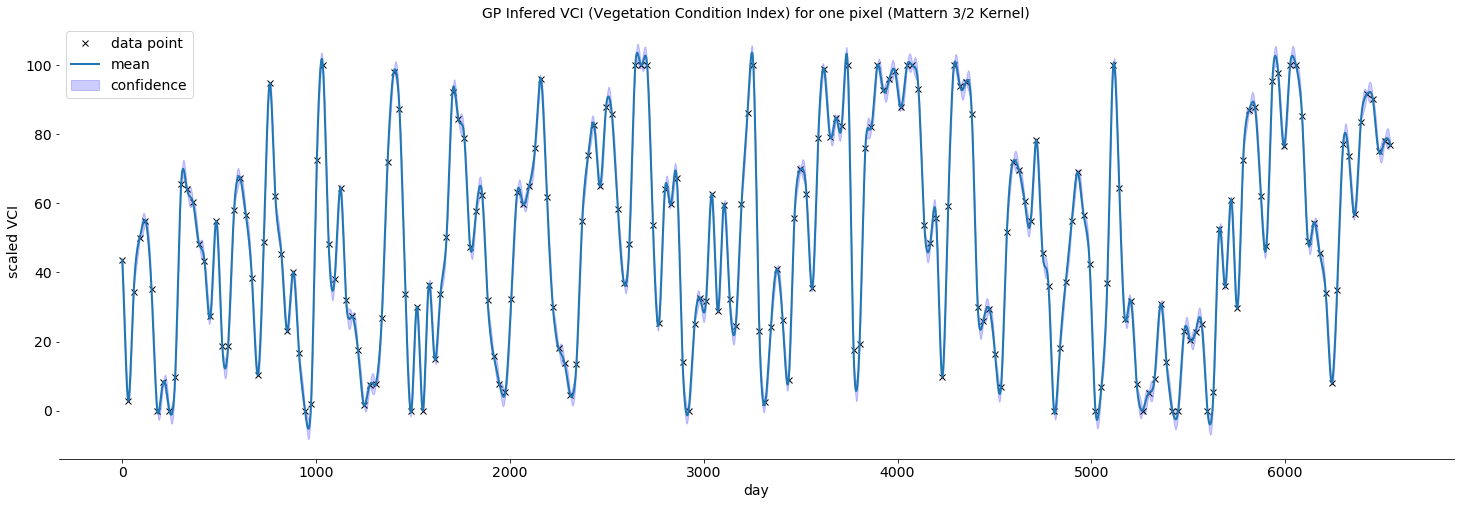

In [164]:
(mean, var) = model2.predict_y(x_test)

# Rescale results
rescaled_mat_mean = (mean*column_stds.iloc[0]) + column_means.iloc[0]
rescaled_mat_var = (var*column_stds.iloc[0])

# Plot the GP and uncertainty bounds
plot_gp(rescaled_mat_mean,rescaled_mat_var, title="(Mattern 3/2 Kernel)")

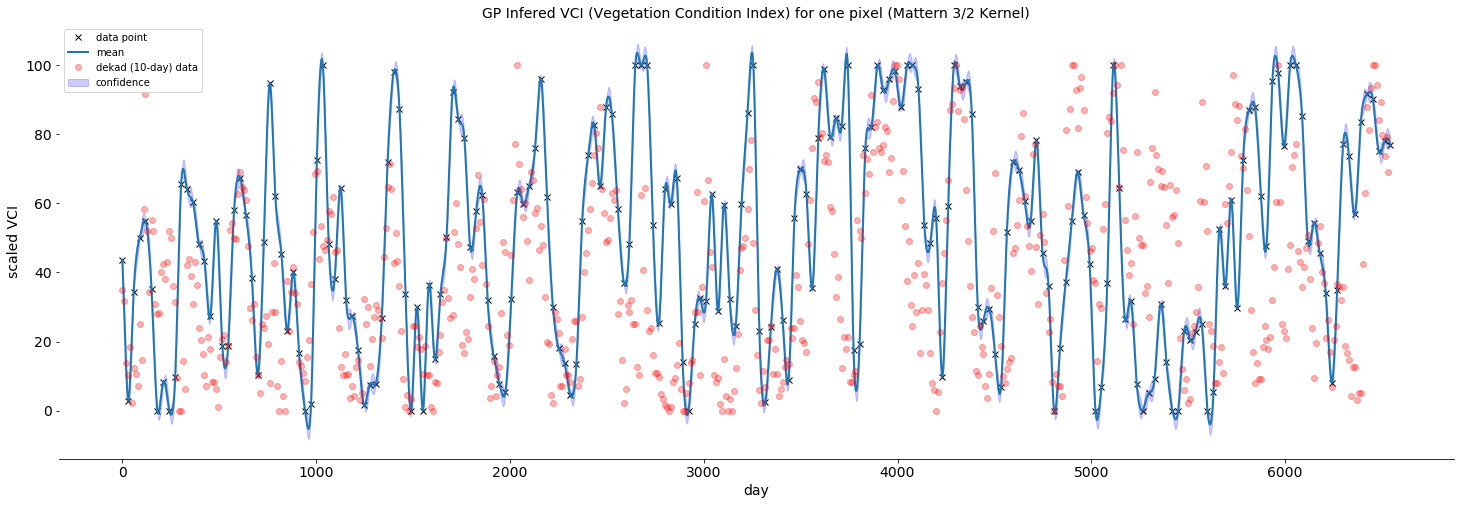

In [165]:
fig, ax = plot_gp(rescaled_mat_mean,rescaled_mat_var, title="(Mattern 3/2 Kernel)")
ax.plot(dekad_x, dekad_y, 'ro', mew=1, alpha=0.3, label="dekad (10-day) data")
plt.legend()